# Opinion Mining Project: IMDB Movie Reviews

This project focuses on sentiment analysis using the IMDB Movie Reviews dataset. The objective is to classify movie reviews as either positive or negative. We will implement two models:
1. **Naive Bayes Classifier** - a classic machine learning algorithm.
2. **LSTM Neural Network** - a deep learning model suited for sequential data.

The project compares the performance of these models and evaluates their effectiveness in classifying movie review sentiments.


# Dataset Description: IMDB Movie Reviews

The IMDB movie reviews dataset is a widely-used dataset for natural language processing tasks, particularly for sentiment analysis. It consists of movie reviews labeled as either positive or negative, making it suitable for binary classification tasks. Here is a detailed description of the dataset's structure and characteristics.

### 1. Overview
- **Dataset Name**: IMDB Movie Reviews
- **Source**: The dataset is available via [TensorFlow Datasets](https://www.tensorflow.org/datasets/catalog/imdb_reviews) and was originally introduced by Andrew Maas et al.
- **Task**: Sentiment analysis – the goal is to classify each review as either positive or negative.

### 2. Dataset Composition
- **Total Samples**: 50,000 movie reviews
- **Training Samples**: 25,000 labeled reviews
- **Test Samples**: 25,000 labeled reviews
- **Classes**:
  - **0**: Negative reviews
  - **1**: Positive reviews

### 3. Class Distribution
The IMDB dataset is **balanced**, with an equal number of positive and negative reviews in both the training and test sets:
- **Training Set**: 12,500 positive reviews, 12,500 negative reviews
- **Test Set**: 12,500 positive reviews, 12,500 negative reviews

This balance ensures that the model is not biased towards either class, which is beneficial for training a model that generalizes well.

### 4. Text Characteristics
- **Review Length**:
  - Reviews vary in length, with some being as short as a few sentences and others extending to multiple paragraphs.
  - **Preprocessing**: For the LSTM model, reviews are truncated or padded to a fixed length of 200 words to ensure consistency in input dimensions.
- **Vocabulary**:
  - The dataset contains a diverse vocabulary due to the wide range of expressions used in movie reviews.
  - Common words related to sentiments, such as "good," "bad," "excellent," and "terrible," are frequently found, as well as genre-specific terms like "plot," "character," and "acting."
  
### 5. Relevance to Sentiment Analysis
The IMDB dataset is highly relevant for sentiment analysis for several reasons:
- **Real-World Language Usage**: The reviews reflect genuine opinions from users, often containing informal language, slang, and varied sentence structures, which provides a realistic challenge for sentiment analysis models.
- **Balanced Sentiment**: The balanced nature of the dataset allows models to learn both positive and negative sentiments equally, making it ideal for training a binary classifier.
- **Wide Range of Sentiments**: Reviews can range from highly positive to extremely negative, providing a good distribution of sentiment intensity. This helps in training models that can capture subtle differences in sentiment.




# Step 1: Import Libraries

We begin by importing the necessary libraries for data processing, model building, and visualization.


In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

# Step 2: Load and Preprocess the Data

We will use the IMDB dataset available through TensorFlow Datasets. The dataset contains 50,000 movie reviews, labeled as positive or negative. We will split the dataset into training and test sets.


In [4]:
# Load and cache IMDB dataset
def load_data():
    data, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)
    train_data, test_data = data['train'].cache(), data['test'].cache()
    return train_data, test_data

train_data, test_data = load_data()


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.2HEY59_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.2HEY59_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.2HEY59_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [18]:
# Print a few raw data samples
for text, label in train_data.take(5):  # Using .take(5) to print 5 samples
    print(f"Text: {text.numpy().decode('utf-8')}")
    print(f"Label: {label.numpy()}")
    print("-" * 80)


Text: This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.
Label: 0
--------------------------------------------------------------------------------
Text: I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a l

Since scikit-learn models require input in NumPy array format, we convert the TensorFlow datasets to lists of text and labels, which are then converted to NumPy arrays. This prepares the data for use in the Naive Bayes model.

In [19]:
# Convert TensorFlow datasets to numpy arrays for compatibility with scikit-learn
def tfds_to_numpy(tf_data):
    texts, labels = [], []
    for text, label in tf_data:
        texts.append(text.numpy().decode('utf-8')) # Decode byte strings to text
        labels.append(label.numpy()) # Extract label as integer
    return texts, np.array(labels)

# Apply the conversion for train and test sets
train_texts, train_labels = tfds_to_numpy(train_data)
test_texts, test_labels = tfds_to_numpy(test_data)

# Step 3: Preprocess Data for Naive Bayes Classifier

For the Naive Bayes classifier, we will use `TfidfVectorizer` to convert the text into numerical features.TF-IDF highlights important words while down-weighting common words, which helps Naive Bayes focus on informative terms.

- max_features=5000: Limits the vocabulary to 5000 words for efficiency.
- stop_words='english': Removes common English stop words.
- token_pattern: Filters out words with less than two alphabetic characters.

In [14]:
# Remove standalone numbers
import re
def remove_numbers(texts):
    return [re.sub(r'\b\d+\b', '', text) for text in texts]

train_texts_no_numbers = remove_numbers(train_texts)
test_texts_no_numbers = remove_numbers(test_texts)

# Preprocess data with TfidfVectorizer for Naive Bayes
def preprocess_naive_bayes(texts, max_features=5000):
    vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english', token_pattern=r'(?u)\b[a-zA-Z]{2,}\b')
    transformed_texts = vectorizer.fit_transform(texts)

      # Print the first 3 samples as dense arrays for readability
    print("Transformed Texts (first 3 samples):\n", transformed_texts[:3].toarray())

    # Print the first 10 feature names to see what words are being vectorized
    print("\nFeature Names (first 10):\n", vectorizer.get_feature_names_out()[:10])
    return transformed_texts, vectorizer

X_train_nb, vectorizer = preprocess_naive_bayes(train_texts_no_numbers)
X_test_nb = vectorizer.transform(test_texts_no_numbers)


Transformed Texts (first 3 samples):
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]

Feature Names (first 10):
 ['abandoned' 'abc' 'abilities' 'ability' 'able' 'abraham' 'absence'
 'absent' 'absolute' 'absolutely']


# Step 4: Train and Evaluate Naive Bayes Classifier

We will train a Multinomial Naive Bayes classifier on the preprocessed data as it is typically the best choice because it handles word frequencies directly. After training, we evaluate the model’s performance using accuracy, classification report, and confusion matrix.


In [15]:
# Train Naive Bayes model with hyperparameter tuning
def train_naive_bayes(X_train, y_train, X_test, y_test, alpha=1.0):
    nb_classifier = MultinomialNB(alpha=alpha)
    nb_classifier.fit(X_train, y_train)
    predictions = nb_classifier.predict(X_test)
    print("Naive Bayes Accuracy:", accuracy_score(y_test, predictions))
    print("Naive Bayes Precision:", precision_score(y_test, predictions))
    print("Naive Bayes Recall:", recall_score(y_test, predictions))
    print("Naive Bayes F1-score:", f1_score(y_test, predictions))
    print("Classification Report:\n", classification_report(y_test, predictions))
    return predictions

nb_predictions = train_naive_bayes(X_train_nb, train_labels, X_test_nb, test_labels)


Naive Bayes Accuracy: 0.83912
Naive Bayes Precision: 0.8527209186220669
Naive Bayes Recall: 0.81984
Naive Bayes F1-score: 0.8359572558936291
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.86      0.84     12500
           1       0.85      0.82      0.84     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



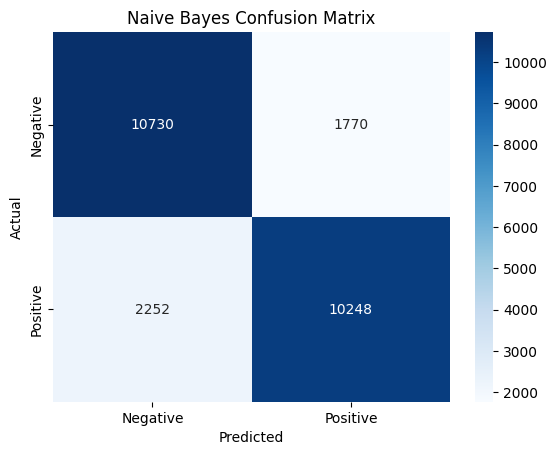

In [20]:

# Plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

plot_confusion_matrix(test_labels, nb_predictions, title="Naive Bayes Confusion Matrix")


There are more false negatives (2,252) than false positives (1,770), meaning the model struggles slightly more with identifying positive reviews compared to negative reviews.


# Step 5: Preprocess Data for LSTM Model

The LSTM model expects sequences of fixed length, so we use tokenization and padding to prepare the text. We limit the vocabulary size to 5,000 words to focus on key words and maintain efficiency.


In [21]:
# Preprocess data for LSTM with Tokenizer and padding
def preprocess_lstm(texts, tokenizer=None, max_len=200, max_vocab=5000):
    if tokenizer is None:
        tokenizer = Tokenizer(num_words=max_vocab, oov_token='<OOV>')
        tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    padded_sequences = pad_sequences(sequences, maxlen=max_len)
    return padded_sequences, tokenizer

X_train_dl, tokenizer = preprocess_lstm(train_texts_no_numbers)
X_test_dl, _ = preprocess_lstm(test_texts_no_numbers, tokenizer=tokenizer)


# Step 6: Define and Compile the LSTM Model

The Sequential model is used because the architecture is simple, with layers added one after another in a single flow.

We use an Embedding layer followed by an LSTM layer to capture sequential dependencies. Dropout layers are added to prevent overfitting. The model outputs a single neuron with a sigmoid activation for binary classification.

Layer Details:

1. Embedding Layer:
Converts words to 128-dimensional vectors, limited to the 5,000 most common words (max_vocab=5000). input_length=200 fixes input size for LSTM.

2. LSTM Layer:
Processes sequences, with 64 units to learn patterns over time. Dropout (20%) prevents overfitting on both outputs and recurrent connections.

3. Dense Layer:
Outputs a probability for binary classification (0-negative, 1-positive), using sigmoid activation for an easy-to-interpret probability.

4. Compilation:
optimizer='adam': Adaptive optimizer for efficient training.
loss='binary_crossentropy': Standard loss for binary classification.
metrics=['accuracy']: Tracks accuracy during training.


In [24]:
# Define and compile the LSTM model
def create_lstm_model(max_vocab=5000, max_len=200):

    model = Sequential([

        Embedding(max_vocab, 128, input_length=max_len),
        LSTM(64, dropout=0.2, recurrent_dropout=0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model
lstm_model = create_lstm_model()
history = lstm_model.fit(X_train_dl, train_labels, epochs=6, batch_size=32, validation_split=0.2)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 104s 162ms/step - accuracy: 0.6771 - loss: 0.5824 - val_accuracy: 0.8304 - val_loss: 0.4026
Epoch 2/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 146s 169ms/step - accuracy: 0.8351 - loss: 0.3866 - val_accuracy: 0.7618 - val_loss: 0.4907
Epoch 3/3
625/625 ━━━━━━━━━━━━━━━━━━━━ 148s 179ms/step - accuracy: 0.8480 - loss: 0.3685 - val_accuracy: 0.8296 - val_loss: 0.4029


782/782 ━━━━━━━━━━━━━━━━━━━━ 37s 47ms/step - accuracy: 0.8497 - loss: 0.4258


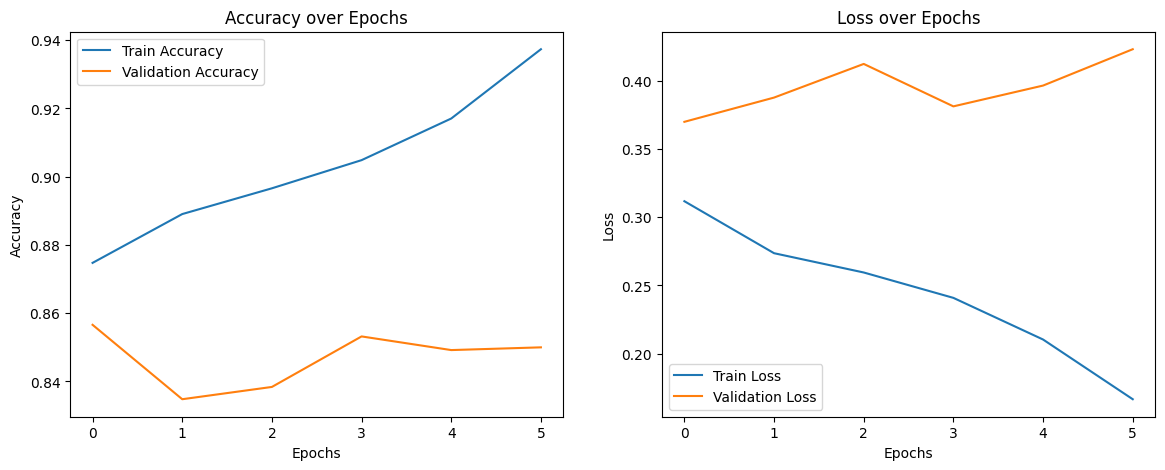

In [30]:
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_dl, test_labels)


# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(14,5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_training_history(history)


# Improving the model
Here are some improvements made to enhance the model:


- Early Stopping: Stops training if the model’s validation loss doesn’t improve, preventing overfitting and saving computation time.
-  another LSTM layer allowing the model to capture more complex sequential dependencies.
- increase of dropout rate

In [32]:
# Enhanced LSTM model with EarlyStopping
def create_lstm_model(max_vocab=5000, max_len=200):
    model = Sequential([
        Embedding(max_vocab, 128, input_length=max_len),
        LSTM(64, dropout=0.3, recurrent_dropout=0.3, return_sequences=True),
        LSTM(32, dropout=0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

lstm_model = create_lstm_model()
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = lstm_model.fit(X_train_dl, train_labels, epochs=6, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 182s 280ms/step - accuracy: 0.6839 - loss: 0.5714 - val_accuracy: 0.7748 - val_loss: 0.4631
Epoch 2/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 186s 254ms/step - accuracy: 0.8162 - loss: 0.4152 - val_accuracy: 0.8370 - val_loss: 0.3710
Epoch 3/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 205s 259ms/step - accuracy: 0.8639 - loss: 0.3377 - val_accuracy: 0.8516 - val_loss: 0.3496
Epoch 4/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 197s 251ms/step - accuracy: 0.8929 - loss: 0.2713 - val_accuracy: 0.8662 - val_loss: 0.3222
Epoch 5/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 201s 250ms/step - accuracy: 0.9107 - loss: 0.2323 - val_accuracy: 0.8650 - val_loss: 0.3299
Epoch 6/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 203s 252ms/step - accuracy: 0.9227 - loss: 0.2056 - val_accuracy: 0.8712 - val_loss: 0.3255


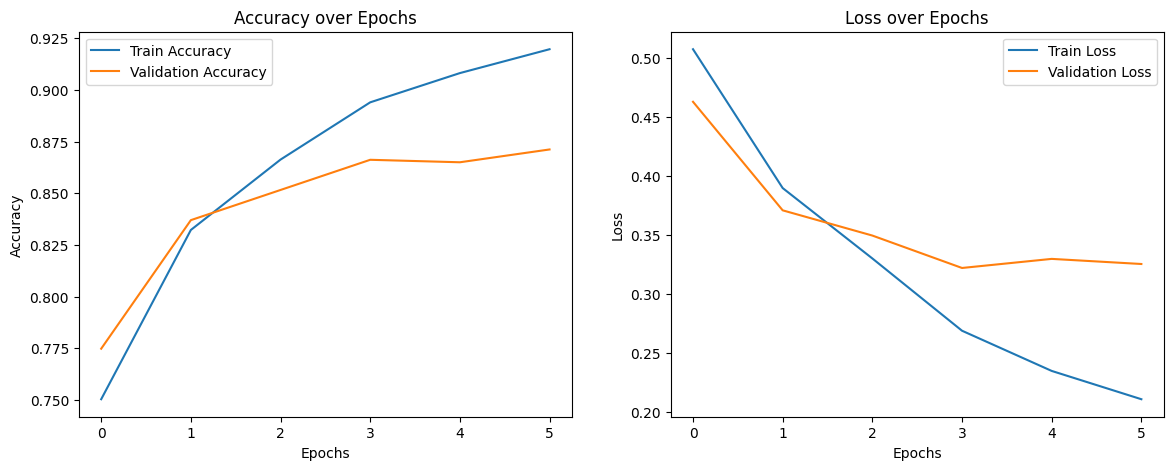

In [33]:

# Plot training history
def plot_training_history(history):
    plt.figure(figsize=(14,5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title("Accuracy over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Loss over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_training_history(history)


782/782 ━━━━━━━━━━━━━━━━━━━━ 55s 70ms/step - accuracy: 0.8619 - loss: 0.3278
LSTM Accuracy: 0.8638799786567688
782/782 ━━━━━━━━━━━━━━━━━━━━ 53s 67ms/step
LSTM Precision: 0.8707915545773213
LSTM Recall: 0.85456
LSTM F1-score: 0.862599426656438
Classification Report for LSTM:
               precision    recall  f1-score   support

           0       0.86      0.87      0.87     12500
           1       0.87      0.85      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



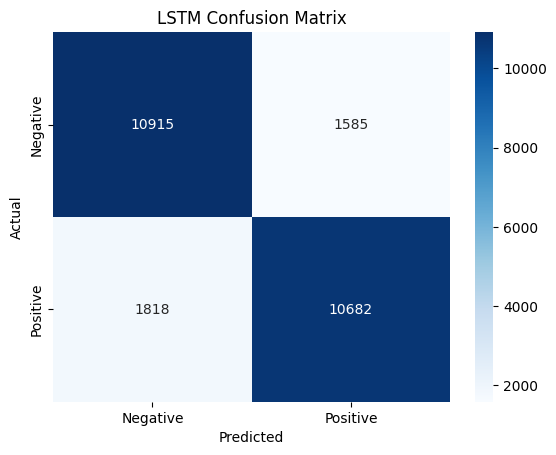

In [34]:

# Evaluate and predict with LSTM
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_dl, test_labels)
print("LSTM Accuracy:", lstm_accuracy)

# LSTM predictions and necessary metrics
lstm_predictions = (lstm_model.predict(X_test_dl) > 0.5).astype("int32")
lstm_predictions = lstm_predictions.flatten()

# Print metrics
print("LSTM Precision:", precision_score(test_labels, lstm_predictions))
print("LSTM Recall:", recall_score(test_labels, lstm_predictions))
print("LSTM F1-score:", f1_score(test_labels, lstm_predictions))
print("Classification Report for LSTM:\n", classification_report(test_labels, lstm_predictions))

# Plot confusion matrix for LSTM
plot_confusion_matrix(test_labels, lstm_predictions, title="LSTM Confusion Matrix")


### Performance Comparison Table

| Metric      | Naive Bayes | LSTM   |
|-------------|-------------|--------|
| Accuracy    |   83.9%          |  86.4%     |
| Precision   |    85.3%         |   87.1%    |
| Recall      |    82.0%         |   85.5%     |
| F1-score    |    83.6%         |   86.3%     |



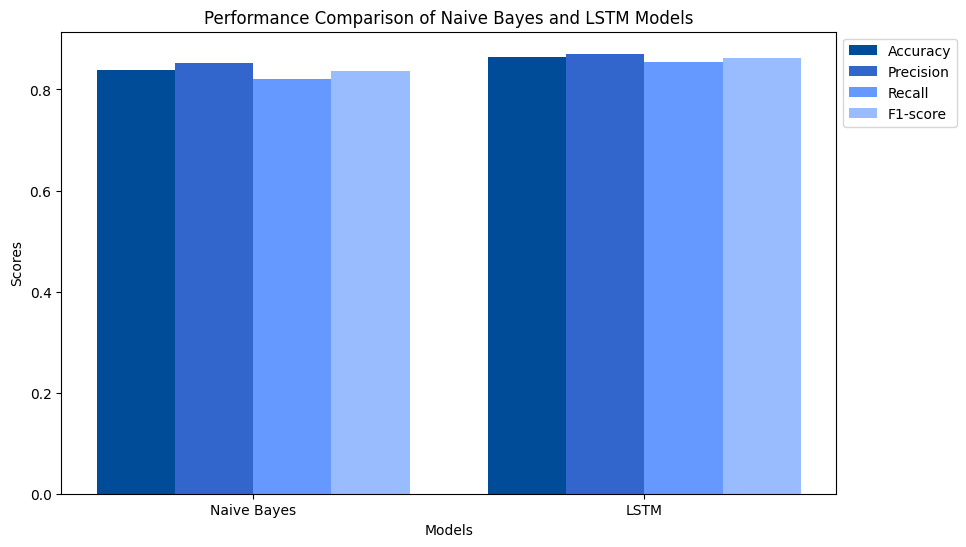

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import numpy as np

# Calculate metrics for Naive Bayes
nb_accuracy = accuracy_score(test_labels, nb_predictions)
nb_precision = precision_score(test_labels, nb_predictions)
nb_recall = recall_score(test_labels, nb_predictions)
nb_f1 = f1_score(test_labels, nb_predictions)

# Calculate metrics for LSTM
lstm_accuracy = accuracy_score(test_labels, lstm_predictions)
lstm_precision = precision_score(test_labels, lstm_predictions)
lstm_recall = recall_score(test_labels, lstm_predictions)
lstm_f1 = f1_score(test_labels, lstm_predictions)

# Store the metrics in lists for plotting
models = ['Naive Bayes', 'LSTM']
accuracy = [nb_accuracy, lstm_accuracy]
precision = [nb_precision, lstm_precision]
recall = [nb_recall, lstm_recall]
f1 = [nb_f1, lstm_f1]

# Define shades of blue for each metric
colors = {
    'Accuracy': '#004c99',    # Dark blue
    'Precision': '#3366cc',   # Medium blue
    'Recall': '#6699ff',      # Light blue
    'F1-score': '#99bbff'     # Very light blue
}

# Plotting the bar chart
x = np.arange(len(models))
width = 0.2  # Width of bars

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - 1.5*width, accuracy, width, label='Accuracy', color=colors['Accuracy'])
ax.bar(x - 0.5*width, precision, width, label='Precision', color=colors['Precision'])
ax.bar(x + 0.5*width, recall, width, label='Recall', color=colors['Recall'])
ax.bar(x + 1.5*width, f1, width, label='F1-score', color=colors['F1-score'])

# Labeling the chart
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Performance Comparison of Naive Bayes and LSTM Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
# Move the legend to the upper right outside the plot area
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()
